## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net2

net = Net2()     # net 2 has less number of feature maps
print(net)

Net2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop_c2): Dropout(p=0.1)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop_c3): Dropout(p=0.2)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop_c4): Dropout(p=0.3)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (drop_c5): Dropout(p=0.4)
  (fc1): Linear(in_features=6400, out_features=1000, bias=True)
  (drop_fc1): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop_fc2): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 32 # power of 2 is better for vectorized operations on GPU

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [8]:
# load test data in batches
batch_size = 32 # power of 2 is better for vectorized operations on GPU

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

RuntimeError: DataLoader worker (pid 6184) is killed by signal: Unknown signal: 0.

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

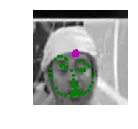

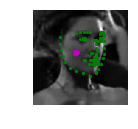

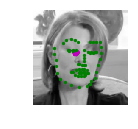

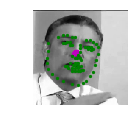

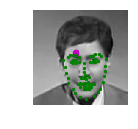

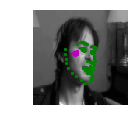

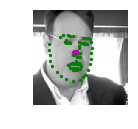

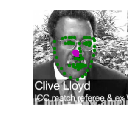

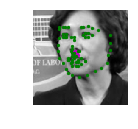

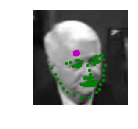

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,20))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=-1)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
# global total_epochs
print_every = 10
train_loss = []
val_loss = []
total_epochs = 0
def train_net(n_epochs):
    global total_epochs
    # send model and all it's parameters to gpu device 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # makesure the running_loss is reset to stop accumulating from previous epochs
        running_loss = 0.0
        
        # reduce the learning rate based on the schedule
        scheduler.step()

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):t
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            # send variables to gpu device
            key_pts = key_pts.to(device)
            images = images.to(device)
            
            # forward pass to get outputs
            output_pts = net(images)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            # backward pass to calculate the weight gradients
            loss.backward()
            # update the weights
            optimizer.step()

            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            # validation phase
            if batch_i % print_every == (print_every-1):    # print every 10 batches,  also print validation results
                net.eval() # Model in inference mode, dropout is off
                
                test_loss = 0
                
                for data in test_loader:
                    # get the input images and their corresponding labels
                    images = data['image']
                    key_pts = data['keypoints']
                    # flatten pts
                    key_pts = key_pts.view(key_pts.size(0), -1)
                    # convert variables to floats for regression loss
                    key_pts = key_pts.type(torch.FloatTensor)
                    images = images.type(torch.FloatTensor)
                    # send variables to gpu device
                    key_pts = key_pts.to(device)
                    images = images.to(device)

                    # forward pass to get outputs
                    output_pts = net(images)
                    # calculate the loss between predicted and target keypoints
                    loss = criterion(output_pts, key_pts)
                    test_loss += loss.item()
                
                # print loss statistics, along with valiudation loss
                print("Epoch: {}".format(epoch + total_epochs + 1), 
                      "Batch: {}".format(batch_i + 1), 
                      "Train Loss: {}".format(running_loss/print_every), 
                      "Val Loss: {}".format(test_loss/len(test_loader)))
                train_loss.append(running_loss/print_every)
                val_loss.append(test_loss/len(test_loader))
                # reset the training loss
                running_loss = 0.0
                net.train() # turn on dropout as we need to train again
    total_epochs += n_epochs

    print('Finished Training')


In [14]:
# train your network
n_epochs = 2 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1 Batch: 10 Train Loss: 0.6485877901315689 Val Loss: 0.184571979790926
Epoch: 1 Batch: 20 Train Loss: 0.315352626144886 Val Loss: 0.29343156933784487
Epoch: 1 Batch: 30 Train Loss: 0.22303858697414397 Val Loss: 0.1814080321788788
Epoch: 1 Batch: 40 Train Loss: 0.20588285177946092 Val Loss: 0.1831014983355999
Epoch: 1 Batch: 50 Train Loss: 0.23046809881925584 Val Loss: 0.1818743833899498
Epoch: 1 Batch: 60 Train Loss: 0.19555203318595887 Val Loss: 0.1882826107740402
Epoch: 1 Batch: 70 Train Loss: 0.22847477048635484 Val Loss: 0.1829960423707962
Epoch: 1 Batch: 80 Train Loss: 0.20152492821216583 Val Loss: 0.17738619446754456
Epoch: 1 Batch: 90 Train Loss: 0.18308371007442475 Val Loss: 0.16193518459796905
Epoch: 1 Batch: 100 Train Loss: 0.2080550506711006 Val Loss: 0.15217396408319472
Epoch: 2 Batch: 10 Train Loss: 0.19821809828281403 Val Loss: 0.15090343862771988
Epoch: 2 Batch: 20 Train Loss: 0.19296694546937943 Val Loss: 0.1978066149353981
Epoch: 2 Batch: 30 Train Loss: 0.166138

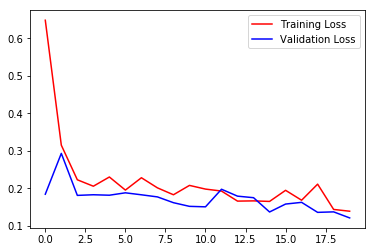

In [15]:
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

Epoch: 3 Batch: 10 Train Loss: 0.1470322698354721 Val Loss: 0.15062836229801177
Epoch: 3 Batch: 20 Train Loss: 0.13708727583289146 Val Loss: 0.12848103493452073
Epoch: 3 Batch: 30 Train Loss: 0.14717987775802613 Val Loss: 0.09886092312633991
Epoch: 3 Batch: 40 Train Loss: 0.14930445104837417 Val Loss: 0.10665077045559883
Epoch: 3 Batch: 50 Train Loss: 0.16983711794018747 Val Loss: 0.165373315513134
Epoch: 3 Batch: 60 Train Loss: 0.13830936551094056 Val Loss: 0.12336214661598205
Epoch: 3 Batch: 70 Train Loss: 0.13423212468624116 Val Loss: 0.10214077055454254
Epoch: 3 Batch: 80 Train Loss: 0.12109436318278313 Val Loss: 0.10309447810053825
Epoch: 3 Batch: 90 Train Loss: 0.11772089079022408 Val Loss: 0.09375593215227127
Epoch: 3 Batch: 100 Train Loss: 0.12646064832806586 Val Loss: 0.08374022327363491
Epoch: 4 Batch: 10 Train Loss: 0.13310020044445992 Val Loss: 0.09903439059853554
Epoch: 4 Batch: 20 Train Loss: 0.09891933128237725 Val Loss: 0.09327526219189167
Epoch: 4 Batch: 30 Train Loss:

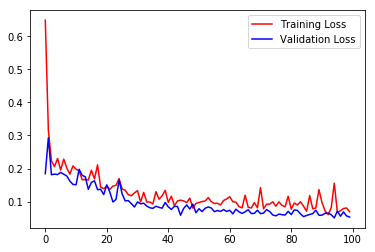

In [16]:
# train a little more if the general loss trend is decreasing
n_epochs = 8 # total 10 epochs

train_net(n_epochs)
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

Epoch: 11 Batch: 10 Train Loss: 0.1001011498272419 Val Loss: 0.05682378970086575
Epoch: 11 Batch: 20 Train Loss: 0.06698841787874699 Val Loss: 0.05719170697033405
Epoch: 11 Batch: 30 Train Loss: 0.11996034309267997 Val Loss: 0.053018296286463734
Epoch: 11 Batch: 40 Train Loss: 0.06552563570439815 Val Loss: 0.06469298474490642
Epoch: 11 Batch: 50 Train Loss: 0.07212215736508369 Val Loss: 0.048189880922436715
Epoch: 11 Batch: 60 Train Loss: 0.06720360592007638 Val Loss: 0.04675996892154217
Epoch: 11 Batch: 70 Train Loss: 0.07551003359258175 Val Loss: 0.045346290618181226
Epoch: 11 Batch: 80 Train Loss: 0.08942704573273659 Val Loss: 0.059787017330527305
Epoch: 11 Batch: 90 Train Loss: 0.10278281830251217 Val Loss: 0.04950906716287136
Epoch: 11 Batch: 100 Train Loss: 0.0822601292282343 Val Loss: 0.05735588118433952
Epoch: 12 Batch: 10 Train Loss: 0.07283215969800949 Val Loss: 0.05825626336038112
Epoch: 12 Batch: 20 Train Loss: 0.08215290941298008 Val Loss: 0.050251766070723534
Epoch: 12 Ba

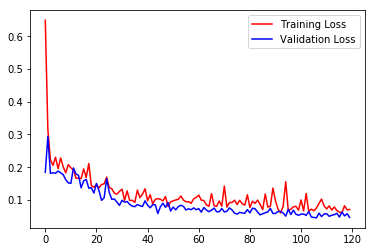

In [17]:
# train a little more if the general loss trend is decreasing
n_epochs = 2 # total 12 epochs

train_net(n_epochs)
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

Epoch: 13 Batch: 10 Train Loss: 0.09149555712938309 Val Loss: 0.0507998263835907
Epoch: 13 Batch: 20 Train Loss: 0.06278240866959095 Val Loss: 0.04911262758076191
Epoch: 13 Batch: 30 Train Loss: 0.08060573004186153 Val Loss: 0.0565418267250061
Epoch: 13 Batch: 40 Train Loss: 0.07583852186799049 Val Loss: 0.04597705960273743
Epoch: 13 Batch: 50 Train Loss: 0.07145001590251923 Val Loss: 0.05924319475889206
Epoch: 13 Batch: 60 Train Loss: 0.06470506004989147 Val Loss: 0.06210721641778946
Epoch: 13 Batch: 70 Train Loss: 0.05712120495736599 Val Loss: 0.052750504985451696
Epoch: 13 Batch: 80 Train Loss: 0.06115152090787888 Val Loss: 0.04551663398742676
Epoch: 13 Batch: 90 Train Loss: 0.06966587118804454 Val Loss: 0.04333132542669773
Epoch: 13 Batch: 100 Train Loss: 0.07947758808732033 Val Loss: 0.04743241131305695
Epoch: 14 Batch: 10 Train Loss: 0.10775146335363388 Val Loss: 0.043477084413170816
Epoch: 14 Batch: 20 Train Loss: 0.06554460301995277 Val Loss: 0.04943596724420786
Epoch: 14 Batch

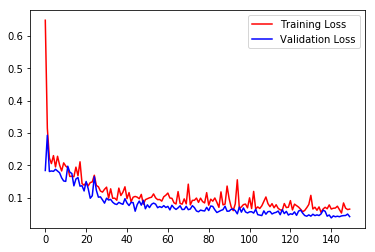

In [18]:
# train a little more if the general loss trend is decreasing
n_epochs = 3 # total 15 epochs

train_net(n_epochs)
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

Epoch: 16 Batch: 10 Train Loss: 0.08348871618509293 Val Loss: 0.052155534327030184
Epoch: 16 Batch: 20 Train Loss: 0.06559652648866177 Val Loss: 0.04741212733089924
Epoch: 16 Batch: 30 Train Loss: 0.06918431743979454 Val Loss: 0.03784378062933683
Epoch: 16 Batch: 40 Train Loss: 0.07025030180811882 Val Loss: 0.03898847952485084
Epoch: 16 Batch: 50 Train Loss: 0.08674800843000412 Val Loss: 0.052744575813412665
Epoch: 16 Batch: 60 Train Loss: 0.07252944223582744 Val Loss: 0.049140290915966035
Epoch: 16 Batch: 70 Train Loss: 0.06089471057057381 Val Loss: 0.046844170913100246
Epoch: 16 Batch: 80 Train Loss: 0.0670255795121193 Val Loss: 0.05235922634601593
Epoch: 16 Batch: 90 Train Loss: 0.09038494937121869 Val Loss: 0.040813127085566524
Epoch: 16 Batch: 100 Train Loss: 0.057544559240341187 Val Loss: 0.04029246591031552
Epoch: 17 Batch: 10 Train Loss: 0.06776470318436623 Val Loss: 0.0443191472440958
Epoch: 17 Batch: 20 Train Loss: 0.09997644983232021 Val Loss: 0.04543205387890339
Epoch: 17 B

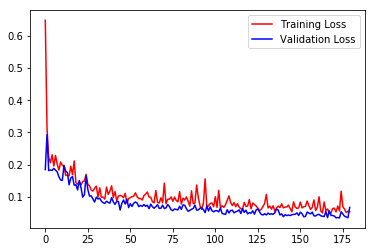

In [22]:
# train a little more if the general loss trend is decreasing
n_epochs = 3 # total 18 epochs

train_net(n_epochs)
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

Epoch: 19 Batch: 10 Train Loss: 0.05026218481361866 Val Loss: 0.032828911989927295
Epoch: 19 Batch: 20 Train Loss: 0.04738906510174275 Val Loss: 0.0458880764618516
Epoch: 19 Batch: 30 Train Loss: 0.0628486841917038 Val Loss: 0.035402674973011014
Epoch: 19 Batch: 40 Train Loss: 0.0664212491363287 Val Loss: 0.032801106423139575
Epoch: 19 Batch: 50 Train Loss: 0.0506999883800745 Val Loss: 0.04525131542235613
Epoch: 19 Batch: 60 Train Loss: 0.04602943472564221 Val Loss: 0.039008522778749465
Epoch: 19 Batch: 70 Train Loss: 0.06063338965177536 Val Loss: 0.03372832242399454
Epoch: 19 Batch: 80 Train Loss: 0.12983006574213504 Val Loss: 0.037721358425915244
Epoch: 19 Batch: 90 Train Loss: 0.061070868745446205 Val Loss: 0.034499069899320604
Epoch: 19 Batch: 100 Train Loss: 0.05107813514769077 Val Loss: 0.04259100198745727
Epoch: 20 Batch: 10 Train Loss: 0.04510540291666985 Val Loss: 0.04403262197971344
Epoch: 20 Batch: 20 Train Loss: 0.0708047453314066 Val Loss: 0.04009376712143421
Epoch: 20 Bat

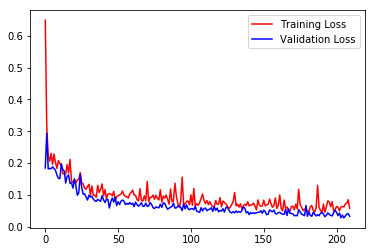

In [23]:
# train a little more if the general loss trend is decreasing
n_epochs = 3 # total 21 epochs

train_net(n_epochs)
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

Epoch: 22 Batch: 10 Train Loss: 0.05122063457965851 Val Loss: 0.03351346950978041
Epoch: 22 Batch: 20 Train Loss: 0.0448105676099658 Val Loss: 0.029743587151169777
Epoch: 22 Batch: 30 Train Loss: 0.06601010728627443 Val Loss: 0.030770930051803588
Epoch: 22 Batch: 40 Train Loss: 0.06261913739144802 Val Loss: 0.03317625187337399
Epoch: 22 Batch: 50 Train Loss: 0.05107297115027905 Val Loss: 0.03384661175310612
Epoch: 22 Batch: 60 Train Loss: 0.04724259041249752 Val Loss: 0.03192045241594314
Epoch: 22 Batch: 70 Train Loss: 0.06658630594611167 Val Loss: 0.029906464889645577
Epoch: 22 Batch: 80 Train Loss: 0.0651855330914259 Val Loss: 0.04597635269165039
Epoch: 22 Batch: 90 Train Loss: 0.06229487769305706 Val Loss: 0.03303039602935314
Epoch: 22 Batch: 100 Train Loss: 0.05325776934623718 Val Loss: 0.03263781186193228
Epoch: 23 Batch: 10 Train Loss: 0.051217107102274895 Val Loss: 0.04073486100882292
Epoch: 23 Batch: 20 Train Loss: 0.04772562272846699 Val Loss: 0.07286332815885543
Epoch: 23 Bat

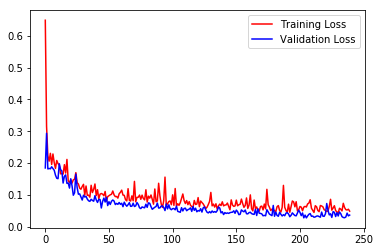

In [26]:
# train a little more just to see how low it can go
n_epochs = 3 # total 24 epochs

train_net(n_epochs)
train_line, = plt.plot(train_loss, 'r', label="Training Loss")
val_line, = plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend(handles=[train_line, val_line], labels=["Training Loss", "Validation Loss"])
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [27]:
# get a sample of test data again
# get the network back to cpu before running some tests
net.to("cpu")
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


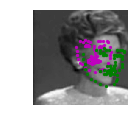

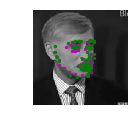

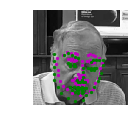

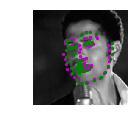

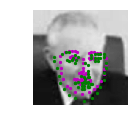

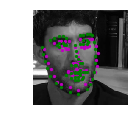

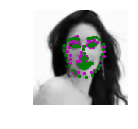

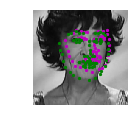

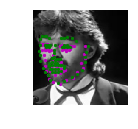

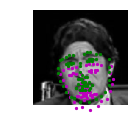

In [28]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [29]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/Net2/no_drop1/'
model_name = 'keypoints_model_e24.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I used Adam optimization method because it is widely used [per-parameter adaptive learning rate](http://cs231n.github.io/neural-networks-3/#ada). I also used learning rate scheduler with exponential decay as the starting learning rate of 0.001 was too high for later epochs and 0.0001 was too low for starting epochs.

I used MSE loss function because it is a great and simplest loss function for Regression problem. There are other alternatives like L1 and Smooth L1 losses, but as our output is normalized between [-1, 1], I was skeptical about using such losses.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
I started with the network architecture with convolutional stride of 5 for first 2 layers and 3 for the later 3, summing to 5 convolution layers. The feature maps were of the size [32, 64, 128, 256, 512]. This then followed by 3 dense layers, where the final layer represents the output layer. All the convolutional layers were sadwiched between Relu and pooling with stride of 2. 

All the dense layers, including final layer were passed through relu, which was a mistake! Later on, I replaced all the Relu activations with elu, because here we want to predict positive as well as negative values. No activations were used after the final dense layer.

In order to learn that the model is overfitting, I printed and plotted train vs validation loss and added dropout layers after each layer except the final layer, with increasing dropout probability from 0.1 to 0.5 for convolution layers and 0.5 for all dense layers.

The test output results weren't very pleasing, so I changed my architecture to have the feature maps of size [16, 32, 64, 128, 256] as we are using grayscale images and trying to extract more features from grayscale images seemed like an overkill. I also changed the convolution stride to 3 for all convolutional layers. 

Finally, after checking the paper reference above (NAIMISHnet), I removed the dropout after first convolutional layer and followed the similar trend as above for the rest of the layers.

Final architecture:

| Layer Name  	| Layer Shape    	| Dropout Probablilty 	|
|-------------	|----------------	|---------------------	|
| Input_1     	| (1, 224, 224)  	|                     	|
| Conv2d_1    	| (16, 222, 222) 	|                     	|
| Elu         	| (16, 222, 222) 	|                     	|
| MaxPool2d_1 	| (16, 111, 111) 	|                     	|
| Conv2d_2    	| (32, 109, 109) 	|                     	|
| Elu         	| (32, 109, 109) 	|                     	|
| MaxPool2d_2 	| (32,  54,  54)    |                     	|
| Dropout_1   	| (32,  54,  54) 	| 0.1                 	|
| Conv2d_3    	| (64,  52,  52) 	|                     	|
| Elu         	| (64,  52,  52) 	|                     	|
| MaxPool2d_3 	| (64,  26,  26)    |                     	|
| Dropout_2   	| (64,  26,  26) 	| 0.2                 	|
| Conv2d_4    	| (128,  24,  24) 	|                     	|
| Elu         	| (128,  24,  24) 	|                     	|
| MaxPool2d_4 	| (128,  12,  12)   |                     	|
| Dropout_3   	| (128,  12,  12) 	| 0.3                 	|
| Conv2d_5    	| (256,  10,  10) 	|                     	|
| Elu         	| (256,  10,  10) 	|                     	|
| MaxPool2d_5 	| (256,   5,   5)   |                     	|
| Dropout_4   	| (256,   5,   5) 	| 0.4                 	|
| Flatten1      | 6400              |                       |
| Dense1        | 1000              |                       |
| Elu           | 1000              |                       |
| Dropout_5     | 1000              | 0.5                   |
| Dense2        | 1000              |                       |
| Elu           | 1000              |                       |
| Dropout_6     | 1000              | 0.6                   |
| Dense3        | 136               |                       |

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

I trained the model on small number of epochs, by starting the training from the previously trained model. Every time, I inspected the train-validation loss and stopped training when the loss did't reduce for more than 5 epochs.

The batch size of 32 is decided as I trained the model on GPU and it is generally a good idea to have power of 2 as GPU cores are also based on some exponential of 2.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [1]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


NameError: name 'net' is not defined

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset
dataiter = iter(test_loader)
sample = dataiter.next()
images = sample['image']
images = images.numpy()
# select an image by index
idx = 3
img = np.squeeze(images[idx])
import cv2
plt.imshow(img, cmap='gray')
plt.show()
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
c = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!